In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [229]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [237]:
PATH_SAM="../Dati/23-04/Run_chall_Co_HHHHR_1000bin_ChargeHistos_4_23_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)

channel = 7

if(channel == 12 or channel == 13 or channel == 1):
    exit()

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -1, 11, 12]

    
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

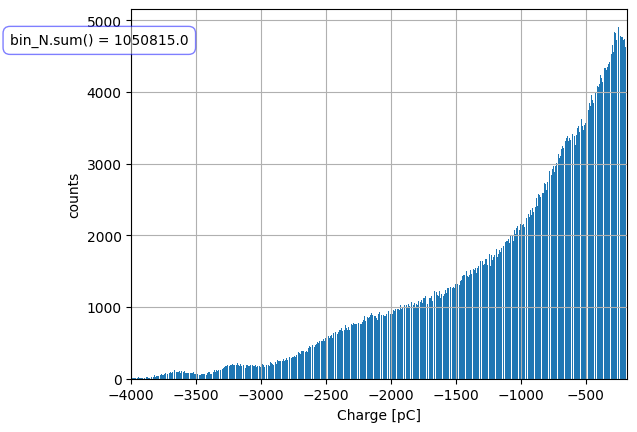

In [238]:
lim_list = [[-1000, -190],  #ch0
            [-1, -1],      #ch1
            [-1000, -175],  #ch2
            [-1000, -145],  #ch3
            [-1000, -165],  #ch4
            [-1000, -175],  #ch5
            [-1000, -155],  #ch6
            [-4000, -180],  #ch7
            [-1000, -170],  #ch8
            [-1000, -160],  #ch9
            [-1000, -120],  #ch10
            [-1000, -165],  #ch11
            [-1, -1],      #ch12
            [-1, -1],      #ch13
            [-1000, -140],  #ch14
            [-1000, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [239]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [240]:
np.where(err_N == 0)

(array([], dtype=int64),)

In [241]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide
sigmoid3 = StepModel(form = "logistic", prefix = "s3_") #Sigmoide



params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 5500, center = -610, sigma = 20))   
params.update(gauss2.make_params(amplitude = 5500, center = -540, sigma = 20)) 
params["g1_amplitude"].min = 0
params["g2_amplitude"].min = 0  

params["e1_decay"].value = -140
params["e1_amplitude"].value = 914


params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))
params.update(sigmoid3.make_params(amplitude = 0, center = -200, sigma = 50))

params["s1_amplitude"].min = 0  
params["s2_amplitude"].min = 0  
params["s3_amplitude"].min = 0  

params["s1_amplitude"].value = 9
params["s1_sigma"].value = 500
params["s2_amplitude"].value = 10 
params["s3_amplitude"].value = 50  

params["s2_amplitude"].max = 120
params["s3_amplitude"].max = 150

params["s1_center"].value = -800  
params["s2_center"].value = -450  
params["s3_center"].value = -440  

params["s2_center"].min = -500  
params["s3_center"].min = -500  

params["s2_sigma"].value = 20
params["s3_sigma"].value = 20  






model = exp1 + gauss1 + gauss2 + sigmoid1 + sigmoid2 #+ sigmoid3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


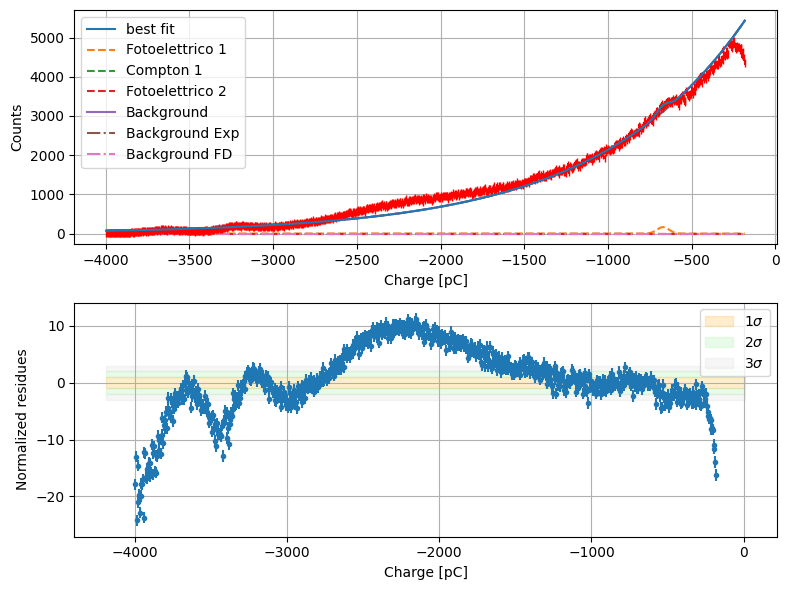

In [242]:
#FIT

result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

#_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['g1_'], label='Fotoelettrico 1', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton 1', ls = "--")
ax1.plot(centers_N, comps['g2_'], label='Fotoelettrico 2', ls = "--")
#ax1.plot(centers_N, comps['s3_'], label='Compton 2', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [245]:
print(result.fit_report())

[[Model]]
    ((((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2787
    # data points      = 776
    # variables        = 17
    chi-square         = 27372.9319
    reduced chi-square = 36.0644689
    Akaike info crit   = 2799.01014
    Bayesian info crit = 2878.13073
    R-squared          = 0.99997934
##  Warning: uncertainties could not be estimated:
    s3_amplitude:  at initial value
    s3_center:     at initial value
    s3_sigma:      at initial value
[[Variables]]
    e1_amplitude:  6692.80493 (init = 914)
    e1_decay:     -877.250291 (init = -140)
    s1_amplitude:  91.8698804 (init = 9)
    s1_center:     65529.8790 (init = -800)
    s1_sigma:      128.841886 (init = 500)
    g1_amplitude:  14792.8690 (init = 5500)
    g1_center:    -672.308070 (init = -6

Picco 1 a -3613.64 pC


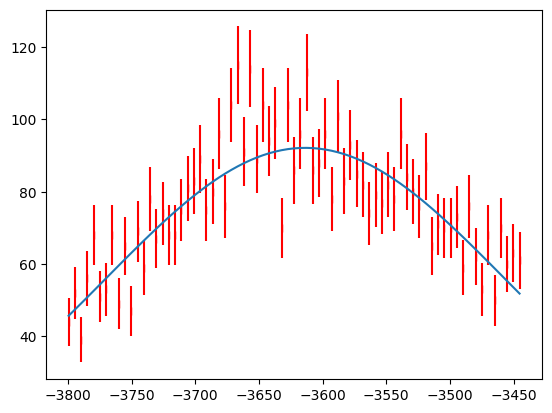

In [256]:
range_1 = [40, 113]
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
model2 = gauss1
params.update(gauss1.guess(bin_N[range_1[0]:range_1[1]], x = centers_N[range_1[0]:range_1[1]]))
result2 = model2.fit(bin_N[range_1[0]:range_1[1]], 
                     params, x = centers_N[range_1[0]:range_1[1]], 
                     weights = 1 / err_N[range_1[0]:range_1[1]])


_ = plt.plot(centers_N[range_1[0]:range_1[1]], result2.best_fit, label='best fit', zorder = 10)
_ = plt.errorbar(centers_N[range_1[0]:range_1[1]], 
             bin_N[range_1[0]:range_1[1]], 
             err_N[range_1[0]:range_1[1]], color = "red", fmt='|')

print(f'Picco 1 a {result2.params["g1_center"].value: .2f} pC')

Picco 2 a -3172.21 pC


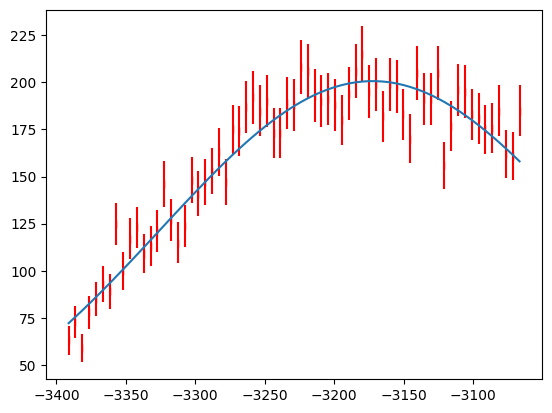

In [263]:
range_2 = [123, 190]
gauss2 = GaussianModel(prefix='g1_')    #Gaussiana
model3 = gauss2
result3 = model3.fit(bin_N[range_2[0]:range_2[1]], 
                     params, x = centers_N[range_2[0]:range_2[1]], 
                     weights = 1 / err_N[range_2[0]:range_2[1]])


_ = plt.plot(centers_N[range_2[0]:range_2[1]], result3.best_fit, label='best fit', zorder = 10)
_ = plt.errorbar(centers_N[range_2[0]:range_2[1]], 
             bin_N[range_2[0]:range_2[1]], 
             err_N[range_2[0]:range_2[1]], color = "red", fmt='|')

print(f'Picco 2 a {result3.params["g1_center"].value: .2f} pC')